In [0]:
### install talib in colab ###
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
!pip install mpl_finance

In [0]:
from google.colab import files

files.upload()  

In [0]:
import talib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_finance import candlestick2_ochl

def Add_Point(signal):
    sig = signal.copy()
    for index, row in sig.iterrows():
        if row.Signal == 0:
            color = 'blue'
            marker = 'v'
            plot_price = row.HIGH
        elif row.Signal == 1:
            color = 'red'
            marker = '^'
            plot_price = row.LOW
        else:
            continue
        plt.plot(index, plot_price, marker = marker, markersize = 15, color = color)
        
        
def Get_MA_Signal_1(data):
    dat = data.copy()
    dat.columns = dat.columns.str.upper()
    dat['_CLOSE'] = dat.CLOSE.shift()
    dat['MA20'] = dat['CLOSE'].rolling(center = False, window = 20).mean()
    dat['Signal'] = dat.apply(lambda x: 1 if x['_CLOSE'] < x['MA20'] < x['CLOSE'] 
                              else (0 if x['_CLOSE'] > x['MA20'] > x['CLOSE'] else 2), axis = 1)
    
    return pd.DataFrame(dat[['HIGH', 'LOW', 'Signal']])


def Get_MA_Signal_2(data):
    dat = data.copy()
    dat.columns = dat.columns.str.upper()
    dat['MA5'] = dat['CLOSE'].rolling(center = False, window = 5).mean()
    dat['MA20'] = dat['CLOSE'].rolling(center = False, window = 20).mean()
    dat['_MA5'] = dat['MA5'].shift()
    dat['_MA20'] = dat['MA20'].shift()
    dat['Signal'] = dat.apply(lambda x: 1 if x.MA5 > x.MA20 and x._MA20 > x._MA5 
                              else (0 if x.MA5 < x.MA20 and x._MA20 < x._MA5 else 2), axis = 1)
    
    return pd.DataFrame(dat[['HIGH', 'LOW', 'Signal']])


def Get_KD_Signal(data):
    dat = data.copy()
    dat.columns = dat.columns.str.upper()
    dat['K'], dat['D'] = talib.STOCH(high = dat['HIGH'].values.astype(float), 
                                     low = dat['LOW'].values.astype(float), 
                                     close = dat['CLOSE'].values.astype(float))
    dat['_K'] = dat['K'].shift(1)
    dat['_D'] = dat['D'].shift(1)
    dat['__K'] = dat['K'].shift(2)
    dat['__D'] = dat['D'].shift(2)
    dat['Signal'] = dat.apply(lambda x: 1 if x._K > x._D and x.__D > x.__K and x._K < 25
                              else (0 if x._K < x._D and x.__D < x.__K and x._K > 75 else 2), axis = 1)

    return pd.DataFrame(dat[['HIGH', 'LOW', 'Signal']])


def Get_MACD_Signal(data):
    dat = data.copy()
    dat.columns = dat.columns.str.upper()
    
    dat['DIF'], dat['MACD'], _ = talib.MACD(dat['CLOSE'].values.astype(float), fastperiod = 12, slowperiod = 26, signalperiod = 9)
    dat['_D'] = dat['DIF'].shift(1)
    dat['_M'] = dat['MACD'].shift(1)
    dat['__D'] = dat['DIF'].shift(2)
    dat['__M'] = dat['MACD'].shift(2)
    
    dat['Signal'] = dat.apply(lambda x: 1 if x._D > x._M and x.__M > x.__D
                              else (0 if x._D < x._M and x.__M < x.__D else 2), axis = 1)

    return pd.DataFrame(dat[['HIGH', 'LOW', 'Signal']])
    
    

def Plot_Candlestick(data, signal, title = ''):
    data.columns = data.columns.str.upper()
    
    if all(name in data.columns.tolist() for name in ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE']):
        fig = plt.figure(figsize = (16, 8))
        x_interval = int(len(data)/5)
        gs = gridspec.GridSpec(3,1)
        # self.k_ax = self.fig.add_subplot(gs[0:2])
        k_ax = fig.add_subplot(gs[0:2])
        k_ax.set_xticks(range(0, len(data['DATE']), x_interval))
        k_ax.set_xticklabels(data['DATE'][::x_interval])
        k_ax.ticklabel_format(useOffset=False, style='plain', axis='y')
        plt.title(title)
        plt.ylabel('Price')
        plt.xlabel('Time')
        candlestick2_ochl(k_ax,
                          data['OPEN'].values,
                          data['CLOSE'].values,
                          data['HIGH'].values,
                          data['LOW'].values,
                          width = 0.6,
                          colorup = 'r',
                          colordown = 'green',
                          alpha = 0.4)
        
        Add_Point(signal)
        
#         ### plot ma ###
#         data['MA5'] = data['CLOSE'].rolling(center = False, window = 5).mean()
#         data['MA20'] = data['CLOSE'].rolling(center = False, window = 20).mean()
#         plt.plot(data.MA5)
#         plt.plot(data.MA20)
        
        ### plot kd ###

        k, d = talib.STOCH(high = data['HIGH'].values.astype(float), 
                           low = data['LOW'].values.astype(float), 
                           close = data['CLOSE'].values.astype(float))
        kd = fig.add_subplot(gs[2], sharex=k_ax)
        kd.set_xticks(range(0, len(data['DATE']), x_interval))
        kd.set_xticklabels(data['DATE'][::x_interval])
        
        data = pd.concat([data, pd.DataFrame(k, columns=['K']), pd.DataFrame(d, columns=['D'])], axis = 1)
        data['U'] = 75
        data['L'] = 25
        plt.plot(data.K)
        plt.plot(data.D)
        plt.plot(data.U,"--", color = 'black')
        plt.plot(data.L,"--", color = 'black')
        plt.ylabel('KD Index')

        
#         ### plot macd ###
#         macd, macdsignal, macdhist = talib.MACD(data['CLOSE'].values.astype(float), 
#                                                 fastperiod = 12, slowperiod = 26, signalperiod = 9)
#         fig2 = fig.add_subplot(gs[2], sharex = k_ax)
#         fig2.set_xticks(range(0, len(data['DATE']), x_interval))
#         fig2.set_xticklabels(data['DATE'][::x_interval])
#         data = pd.concat([data,
#                           pd.DataFrame(macd, columns=['DIF']), 
#                           pd.DataFrame(macdsignal, columns=['MACD'])], axis = 1)
#         plt.plot(data.MACD)
#         plt.plot(data.DIF)
#         plt.ylabel('MACD Index')
        
        plt.title(title)
        plt.xlabel('Time')
        plt.legend()
        
    else:
        print('Column(Date, OPEN, HIGH, LOW or CLOSE) is missing!')

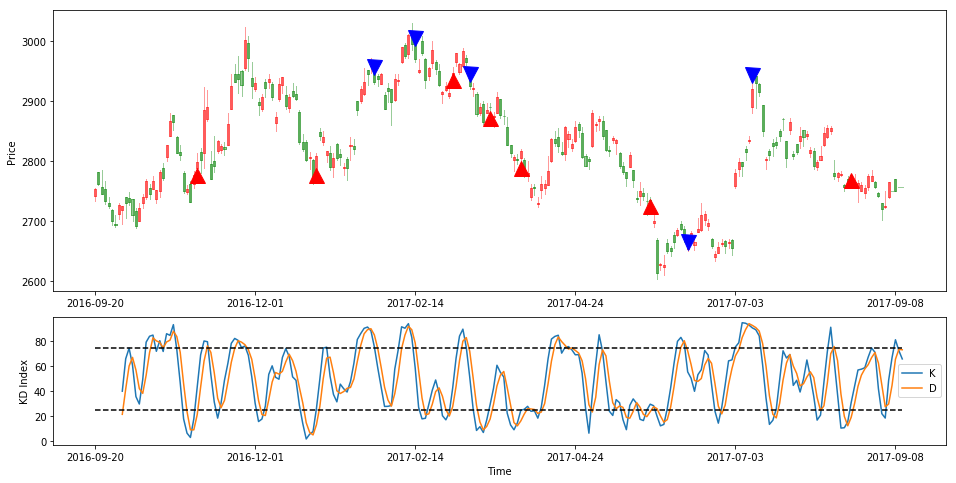

In [0]:
import talib
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('ex_data.csv')

signal = Get_MA_Signal_1(data)
signal = Get_MA_Signal_2(data)
signal = Get_KD_Signal(data)
# signal = Get_MACD_Signal(data)
Plot_Candlestick(data, signal)
